# Отчет по проекту: *подготовка и анализ промежуточных результатов АВ-тестирования для обоснования способа увеличения выручки интернет магазина*

## Даты выполнения проекта: 16.08.2022 - 19.08.2022 
Указанные даты не включают период организационно-технических мероприятий Заказчика по проведению АВ-тестирования, а также период мозгового штурма совместно с маркетингом Заказчика по выдвижению предложений (гипотез) по методам повышения выручки.

## Цели и задачи проекта

### Цели проекта:
1. Дать обоснованные АВ-тестированием предложения по увеличению выручки
2. Оптимизировать сроки и затраты АВ-тестирования при сохранении бизнес-значимости результатов.
3. Провести корректный анализ промежуточных результатов АВ-тестирования в точке контроля их проведения, дать рекомендации по дальнейшему тестированию.

### Задачи проекта:
1. Изучить предоставленный отделом маркетинга список гипотез по увеличению выручки.
2. На базе полученного предварительным исследованием скоринга различных параметров гипотез осуществить приоритезацию гипотез для АВ-тестирования различными методиками.
3. **Вне данного проекта** находится принятие решения на базе приоретизации о том, какая гипотеза будет тестироваться, а также организационно-техническое обеспечение и проведение самих тестов.
4. **Вне данного проекта** находится процедура определения А и В групп пользователей, включая:
 * проверку факта их репрезентативности для популяции всех пользователей интернет-магазина;
 * проверку факта, что **все** они были активны в период проведения АВ-тестирования (то есть совершили как минимум один аутентифицированный визит на сайт магазина);
 * а также проверку АА-тестированием их статистической равнозначности по всем параметрам, потенциально влияющим на выручку и на принятие пользователями изменений для группы В, предлагаемых в тестируемой гипотезе.
5. Провести проверку статистической значимости промежуточных результатов АВ тестирования в точке контроля.
6. Принять решение по требуемому уровню статистической значимости для принятия нулевой гипотезы.
7. Определить мощность проведенного АВ-тестирования.
8. Сделать выводы в отношении нулевой гипотезы - есть ли основания ее отвергнуть.
9. Дать рекомендации по целесообразности продолжения дальнейшего тестирования.

## Исходные данные

### Часть 1 - проводится до начала АВ-тестирования
Получен файл /datasets/**hypothesis.csv** , содержащий информацию о гипотезах по увеличению выручки со следующими полями записей в нем:
* `Hypothesis    —` краткое описание гипотезы;
* `Reach         —` охват пользователей по 10-балльной шкале;
* `Impact        —` влияние на пользователей по 10-балльной шкале;
* `Confidence    —` уверенность в гипотезе по 10-балльной шкале;
* `Efforts       —` затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


### Часть 2 - проводится в точке контроля промежуточных результатов АВ-тестирования
Получен файл  /datasets/**orders.csv** ,  содержащий информацию о заказах, совершенных пользователями групп А и В за период тестирования (**NB!**: пользователи групп А и В, не совершившие ни одного заказа, не присутствуют в данном файле) со следующими полями записей в нем:
* `transactionId —` идентификатор заказа;
* `visitorId     —` идентификатор пользователя, совершившего заказ;
* `date          —` дата, когда был совершён заказ;
* `revenue       —` выручка заказа;
* `group         —` группа A/B-теста, в которую попал заказ.

Получен файл /datasets/**visitors.csv** , содержащий агрегированную по дням АВ-тестирования информацию о "посещениях" магазина (заход на сайт с успешной аутентификацией), совершенных пользователями групп А и В за период тестирования (**NB!**: мы предполагаем, что все пользователи групп А и В зашли на сайт магазина как мининун один раз за время проведения АВ-тестирования - в противном случае надо опять проводить АА-тест), со следующими полями записей в нем:
* `date          —` дата;
* `group         —` группа A/B-теста;
* `visitors      —` количество пользователей в указанную дату в указанной группе A/B-теста \*)

\* *) уникальных пользователей для данного дня*


In [1]:
# приготовимся к использованию нужных библиотек:

import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

# Часть 1.  Приоритезация гипотез
До начала АВ-тестирования Заказчику следует определиться, какую гипотезу он будет проверять в первую очередь.  Судя по предоставленному описанию полей, файл с гипотезами содержит также результаты экспертного опроса для сравнения гипотез методами (R)ICE.  Мы планируем расчитать ICE-score и RICE-score и приоритезировать список гипотез соответственно:

$$ ICE = {Impact * Confidence\over Efforts} \space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space RICE = {Reach * Impact * Confidence \over Efforts}$$

Сразу заметим, что поскольку бизнес целью является повышение revenue, а не улучшение удельных метрик одного пользователя (LTV, CAC, ROI, CR, RR), то финальная приоритезация будет сделана по RICE-score

In [2]:
# считываем датасет в одноименную переменную:
# (применяем try-except, чтобы работало и локально, и на тренажере)

try:
    hypothesis_df = pd.read_csv('datasets/hypothesis.csv')
except:
    hypothesis_df = pd.read_csv('/datasets/hypothesis.csv')

hypothesis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


## Полный список гипотез

In [3]:
# поскольку опрос оценок для расчета скоринга уже проведен, технически нам не нужны сами описания гипотез, 
# но для полноты проекта выведем их полностью в данный отчет: 
# (не смотря на краткость описания, простой вывод датасета не позволяет прочитаь текст с описанием гипотез полностью, поэтому:)

print()
print('ПОЛНЫЙ СПИСОК ПРЕДЛОЖЕННЫХ МЕТОДОВ (ГИПОТЕЗ) ПОВЫШЕНИЯ ВЫРУЧКИ ИНТЕРНЕТ МАГАЗИНА:')
print()
for i in list(hypothesis_df.index):
    print('Гипотеза №', i,': ', hypothesis_df.loc[i,'Hypothesis'])


ПОЛНЫЙ СПИСОК ПРЕДЛОЖЕННЫХ МЕТОДОВ (ГИПОТЕЗ) ПОВЫШЕНИЯ ВЫРУЧКИ ИНТЕРНЕТ МАГАЗИНА:

Гипотеза № 0 :  Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
Гипотеза № 1 :  Запустить собственную службу доставки, что сократит срок доставки заказов
Гипотеза № 2 :  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
Гипотеза № 3 :  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар
Гипотеза № 4 :  Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей
Гипотеза № 5 :  Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов
Гипотеза № 6 :  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию
Гипотеза № 7 :  Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
Гипотеза № 8 :  Запустить акцию, дающу

Да уж: формулировки действительно очень краткие, доверимся маркетингу, что они знают детали для организации соответствующего тестирования!

## Приоритезация гипотез по интенсивному критерию ICE

In [4]:
hypothesis_df['ICE_score'] = round( ( hypothesis_df['Impact'] * hypothesis_df['Confidence'] ) / hypothesis_df['Efforts'] , 2)

ICE_priority_npa = np.array( hypothesis_df.sort_values('ICE_score', ascending=False).index )

hypothesis_df = hypothesis_df.join(pd.DataFrame(
    np.array(range(len(ICE_priority_npa))), index=ICE_priority_npa, columns=['ICE_priority']
) )
hypothesis_df['ICE_priority'] = hypothesis_df['ICE_priority'] + 1 # иначе нумерация с нуля

In [5]:
print()
print('ТАБЛИЦА: СПИСОК ГИПОТЕЗ В ПОРЯДКЕ УБЫВАНИЯ ПРИОРИТЕТА СОГЛАСНО ICE-SCORE')
hypothesis_df.sort_values('ICE_score', ascending=False)[['Hypothesis','ICE_score','ICE_priority']]


ТАБЛИЦА: СПИСОК ГИПОТЕЗ В ПОРЯДКЕ УБЫВАНИЯ ПРИОРИТЕТА СОГЛАСНО ICE-SCORE


,Hypothesis,ICE_score,ICE_priority
8,"Запустить акцию, дающую скидку на товар в день...",16.20,1
0,"Добавить два новых канала привлечения трафика,...",13.33,2
7,Добавить форму подписки на все основные страни...,11.20,3
6,Показать на главной странице баннеры с актуаль...,8.00,4
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00,5
1,"Запустить собственную службу доставки, что сок...",2.00,6
5,"Добавить страницу отзывов клиентов о магазине,...",1.33,7
3,"Изменить структура категорий, что увеличит кон...",1.12,8
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00,9


## Приоритезация гипотез по экстенсивному критерию RICE

In [6]:
hypothesis_df['RICE_score'] = round( 
    ( hypothesis_df['Reach'] * hypothesis_df['Impact'] * hypothesis_df['Confidence'] ) / hypothesis_df['Efforts'] , 2)

RICE_priority_npa = np.array( hypothesis_df.sort_values('RICE_score', ascending=False).index )

hypothesis_df = hypothesis_df.join(pd.DataFrame(
    np.array(range(len(ICE_priority_npa))), index=RICE_priority_npa, columns=['RICE_priority']
) )
hypothesis_df['RICE_priority'] = hypothesis_df['RICE_priority'] + 1 # иначе нумерация с нуля

In [7]:
print()
print('ТАБЛИЦА: СПИСОК ГИПОТЕЗ В ПОРЯДКЕ УБЫВАНИЯ ПРИОРИТЕТА СОГЛАСНО RICE-SCORE')
hypothesis_df.sort_values('RICE_score', ascending=False)[['Hypothesis','ICE_score','RICE_score','ICE_priority','RICE_priority']]


ТАБЛИЦА: СПИСОК ГИПОТЕЗ В ПОРЯДКЕ УБЫВАНИЯ ПРИОРИТЕТА СОГЛАСНО RICE-SCORE


,Hypothesis,ICE_score,RICE_score,ICE_priority,RICE_priority
7,Добавить форму подписки на все основные страни...,11.20,112.0,3,1
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00,56.0,5,2
0,"Добавить два новых канала привлечения трафика,...",13.33,40.0,2,3
6,Показать на главной странице баннеры с актуаль...,8.00,40.0,4,4
8,"Запустить акцию, дающую скидку на товар в день...",16.20,16.2,1,5
3,"Изменить структура категорий, что увеличит кон...",1.12,9.0,8,6
1,"Запустить собственную службу доставки, что сок...",2.00,4.0,6,7
5,"Добавить страницу отзывов клиентов о магазине,...",1.33,4.0,7,8
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00,3.0,9,9


**Анализ таблицы**: мы видим, что при переходе от интенсивного критерия ICE к экстенсивному критерию RICE приоритеты сильно поменялись:
* Номер 1 по ICE - стал номером 5 по RICE;
* Номер 2 по ICE - стал номером 3 по RICE;
* И победитель: **номер 3 по ICE - стал номером 1 по RICE - это гипотеза номер 8** (номер гипотезы = индекс + 1).

Не изменили позиций только:
* Номер 4 по ICE - остался номером 4 по RICE;
* Номер 9 по ICE - остался номером 9 по RICE.

## Выводы по Части 1 проекта:
1. Поскольку бизнес задачей проекта является увеличение ревеню, то фактор максимизации охвата гипотезой пользовательской базы является важным.  В связи с этим мы рекомендуем рейтинг RICE для предложенных гипотез.
2. Согласно рейтингу RICE самой приоритетной является 8-ая гипотеза (из 9-и расмотренных), она также показала неплохой рейтинг ICE по улучшению удельных метрик пользователя (по ICE 8-ая гипотеза была на 3-ем месте из 9-и).
3. Предполагаемая **причина** определившегося лидера - гипотеза адресует всех пользователей интернета, которые еще не знают о магазине, то есть охват самый большой из возможных.
4. Остальные детали приоритезации гипотез приведены в Таблице "Список гипотез в порядка убывания согласно RICE-score" выше. (**NB!**: номера гипотез на единицу больше нумерации индексов в таблице, из-за начала последних с нуля).

In [8]:
print()
print('ПЕРВОЕ МЕСТО ПО РЕЙТИНГУ RICE СРЕДИ СПИСКА ПРЕДЛОЖЕННЫХ МЕТОДОВ (ГИПОТЕЗ) ПОВЫШЕНИЯ ВЫРУЧКИ ИНТЕРНЕТ МАГАЗИНА:')
hypothesis_df.loc[7,'Hypothesis']


ПЕРВОЕ МЕСТО ПО РЕЙТИНГУ RICE СРЕДИ СПИСКА ПРЕДЛОЖЕННЫХ МЕТОДОВ (ГИПОТЕЗ) ПОВЫШЕНИЯ ВЫРУЧКИ ИНТЕРНЕТ МАГАЗИНА:


'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'

# Часть 2. Анализ А/В теста

## Предобработка данных

### Считывание датасетов в переменные.  Исправление нотаций и приведение типов данных

In [9]:
try:
    orders_df = pd.read_csv('datasets/orders.csv')
except:
    orders_df = pd.read_csv('/datasets/orders.csv')

orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
# приводим типы и нотацию
orders_df['date'] = pd.to_datetime(orders_df['date'])
orders_df.rename(columns = {'transactionId':'transaction_id','visitorId':'visitor_id'}, inplace=True)

In [11]:
try:
    visitors_df = pd.read_csv('datasets/visitors.csv')
except:
    visitors_df = pd.read_csv('/datasets/visitors.csv')

visitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
# приводим типы
visitors_df['date'] = pd.to_datetime(visitors_df['date'])

### Предварительное ознакомление с данными

In [13]:
orders_df.head() # убедимся, что в датасете присутствует только дата заказа - без момента времени заказа (для сшивок)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**Вывод**: датасеты можно объединять по полю `date`

In [14]:
# посмотрим период тестирования и основную статистику цены заказа 
presentation_df = orders_df.describe(datetime_is_numeric=True)[['date','revenue']]
presentation_df['revenue'] = presentation_df['revenue'].astype('int')
presentation_df

,date,revenue
count,1197,1197
mean,2019-08-15 13:06:46.015037696,8348
min,2019-08-01 00:00:00,50
25%,2019-08-08 00:00:00,1220
50%,2019-08-15 00:00:00,2978
75%,2019-08-23 00:00:00,8290
max,2019-08-31 00:00:00,1294500
std,NaN,39191


#### Выводы по orders_df:
* Период тестирования по датасету `orders_df` - **с 2019-08-01 по 2019-08-31**.
* Распределение цены заказа сильно перекошено выбросами:
 * Медианное значение 2978;
 * Среднее значение 8348 (в 2.8 раза превышает медианное значение);
 * Стандартное отклонение 39191 (в 4.7 раз превышает среднее значение - при неотрицательности самой случайной величины);
 * Максимальное значение 1294500 (в 435 раз больше медианного значения).

In [15]:
visitors_df.describe(datetime_is_numeric=True)

,date,visitors
count,62,62.000000
mean,2019-08-16 00:00:00,607.290323
min,2019-08-01 00:00:00,361.000000
25%,2019-08-08 06:00:00,534.000000
50%,2019-08-16 00:00:00,624.500000
75%,2019-08-23 18:00:00,710.500000
max,2019-08-31 00:00:00,770.000000
std,NaN,114.400560


#### Выводы по visitors_df:
* Данные полны - 62 записи = 31 день для 2 групп: А и В.
* Период тестирования по датасету `visitors_df` - **с 2019-08-01 по 2019-08-31**.
* Распределение кол-ва посететелей в день выглядит похожим на нормальное:
 * Медианное значение 625;
 * Среднее значение 607 (отличие от медианного значения всего 2.9%);
 * Стандартное отклонение 114 (составляет примерно 1/6 от среднего/медианного значения);
 * Минимальное значение 361 еще далеко от нуля - по середине между центом распределения и нулем, и в пределах двух с половиной сигма от центра распределения;
 * Максимальное значение в пределах полторы сигма от центра распределения.

In [16]:
# сравним активность пользователей в разных группах - чтобы оценить качество выделения групп для АВ-теста: 
print('Кумулятивная активность в группе А =', round(visitors_df.query('group=="A"')['visitors'].mean()), 'визитов в день')
print('Кумулятивная активность в группе B =', round(visitors_df.query('group=="B"')['visitors'].mean()), 'визитов в день')

Кумулятивная активность в группе А = 604 визитов в день
Кумулятивная активность в группе B = 610 визитов в день


**Вывод**: пока претензий к подбору групп для АВ-теста нет

### Проверка данных на непротиворечивость
Данный раздел был добавлен после того, как в дальнейшам анализе появились расхождения в кол-вах покупателей в разных группах - в сумме они получались явно больше чем общее кол-во покупателей.  Было сделано предположение, что возможно в исходном датасете orders_df есть записи, где один и тот де visitor_id ошибочно отнесен к разным группам!

Воспользуемся свойством inner merge оставлять только те комбинации записей, для которых ключ сшивания совпал в обоих датасетах - разделим датасет orders_df на группы и сошьем их inner merge по visitor_id: если противоречий в orders_df нет, то в результате должно получиться ноль записей.

In [17]:
orders_df.query('group=="A"').merge(orders_df.query('group=="B"'), how='inner', on='visitor_id', suffixes=('_A','_B')).head(6)

,transaction_id_A,visitor_id,date_A,revenue_A,group_A,transaction_id_B,date_B,revenue_B,group_B
0,2961555356,4069496402,2019-08-15,400,A,1473132782,2019-08-12,640,B
1,2223239646,199603092,2019-08-15,3488,A,437656952,2019-08-02,3488,B
2,62794304,199603092,2019-08-22,6976,A,437656952,2019-08-02,3488,B
3,2971973105,199603092,2019-08-27,2790,A,437656952,2019-08-02,3488,B
4,1941707234,199603092,2019-08-12,6438,A,437656952,2019-08-02,3488,B
5,2220299125,3803269165,2019-08-15,700,A,473864496,2019-08-23,2360,B


**Так и есть**: например, в строках с индексами 1,2,3,4 мы видим одного и того же пользователя, который совершил 2-ого августа покупку как пользователь В, а позже покинул группу и совершил 4 покупки 12-ого, 15-ого, 22-ого и 27-ого августа уже как пользователь группы А.  Видимо, это как раз случай "фликера", которого суппорт вывел из группы В после его жалоб на изменения пользовательского опыта и требований "вернуть все как было".

In [18]:
flicker_list = list(orders_df.query('group=="A"').merge(orders_df.query('group=="B"'),how='inner',on='visitor_id').groupby(
    by='visitor_id', as_index=False).agg('min')['visitor_id'] )
print('Обнаружены', len(flicker_list), 
      'фликеров, сменивших группу во время тестов и подлежащих удалению из анализа результатов АВ-тестирования')

Обнаружены 58 фликеров, сменивших группу во время тестов и подлежащих удалению из анализа результатов АВ-тестирования


In [19]:
orders_df = orders_df.query('visitor_id not in @flicker_list').reset_index(drop=True)

In [20]:
# повторно посмотрим период тестирования и основную статистику цены заказа после удаления фликеров
presentation_df = orders_df.describe(datetime_is_numeric=True)[['date','revenue']]
presentation_df['revenue'] = presentation_df['revenue'].astype('int')
presentation_df

,date,revenue
count,1016,1016
mean,2019-08-15 07:47:42.992125952,8300
min,2019-08-01 00:00:00,50
25%,2019-08-07 00:00:00,1190
50%,2019-08-15 00:00:00,2955
75%,2019-08-23 00:00:00,8134
max,2019-08-31 00:00:00,1294500
std,NaN,42121


### Предварительные выводы о данных - промежуточных результатах АВ-тестирования:
1. Анализ промежуточных результатов проводится за период с 2019-08-01 по 2019-08-31.
2. Данные датасетов orders_df и visitors_df по пользователям групп А и В полны за указанный период.
3. В датасете orders_df обнаружено 58 фликеров, сменивших группу во время тестирования - их заказы удалены, так как учет фликеров привел бы к появлению в статистике пользователей видевших оба варианта системы.
4. После удаления фликеров датасет orders_df "похудел" на 15.1% - **это аномальное кол-во фликеров, на основании которого уже можно признать АВ-тест неудачным**.  Однако продолжим "тренировку" на данном проекте.
5. К сожалению у нас нет возможности удалить фликеров из датасета visitors_df, так как он уже предагрегирован, и нет возможности отфильтровать его по списку фликеров - см. также пункт с NB! ниже.
6. Распределение посетителей сайта по дням АВ-тестирования ожидается близким к нормальному.
7. Распределение цены заказа по заказам ожидается сильно искаженным большими выбросами.  Ожидается необходимость удаления наиболее крупных заказов для корректного сравнение эффекта от применения рекомендаций гипотезы к группе В - в противном случае флуктуации от "людей-Х" превысят эффект!
8. **NB!**: В данных присутствует досадное ограничение вариантов анализа: данные датасета visitors_df уже агрегированы по дням АВ-тестирования, поэтому у нас нет возможности корректно удалять отдельные visitor_id из данных по посещаемости сайта интернет магазина

### Претензии к исходным данным по их недостаточности для корректного анализа
Исходные данные предоставлены уже частично предагрегированными, поэтому в них отсутствует информация по тому какие visitor_id посещали сайт интернет-магазина в дни тестирования.  В связи с этим при анализе невозможно следующее:
1. неизвестны даже размеры групп А и В;
2. как следствие из факта выше нельзя корректно посчитать средние метрики по группе, кроме дневных и их производных;
3. нельзя корректно удалять отдельные visitors_id - например, 15% уже обнаруженных фликеров и/или источники огромных заказов (сами огромные заказы можно удалять, но корректность даже дневных метрик при этом попадает под вопрос);
4. **рекомендации к исправлению исходных данных**: нужен датасет по сессиям с полями `date`, `visitor_id` и `group`, и желательно также списки групп А и В.  При этом текущий датасет visitors_df становится необязателен. 

### Решение о проведении условно-корректного анализа на имеющихся данных
После обсуждения данного вопроса с командой когорты в Slack, было принято решение не ждать исправления исходных данных, но делать проект в части расчета размеров групп по формулам теор-части спринта, отмечая попутно в каких местах в них ошибка и как она исправляется на корректных исходных данных.

### Предобработка исходных данных завершена - датасеты для анализа `orders_df` и `visitors_df`

Выведем датасеты, готовые к условно-корректному анализу:

In [21]:
print('--------------------------------------- orders_df ----------------------------')
orders_df.info()
print('-------------------------------------- visitors_df ---------------------------')
visitors_df.info()

--------------------------------------- orders_df ----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 39.8+ KB
-------------------------------------- visitors_df ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  6

#### Параметризация дней начала и останова АВ-тестирования

In [22]:
# также создадим переменные начала и конца тестирования:
start_date = dt.datetime(2019,8,1)
stop_date = dt.datetime(2019,8,31)
print('Начало AB-тестирования - переменная start_date ='.rjust(75), start_date.date())
print('Остановка тестирования для промежуточного анализа - переменная stop_date ='.rjust(75), stop_date.date())

                           Начало AB-тестирования - переменная start_date = 2019-08-01
 Остановка тестирования для промежуточного анализа - переменная stop_date = 2019-08-31


## График кумулятивной выручки по группам (корректность 100%)

**Определение**: *Кумулятивная выручка на дату d_day - это суммарная выручка со дня начала тестирования по день d_day включительно*. 

### Построение кумулятивного датасета `orders_cumul_df`

В датасете orders_df записи всех заказов - чтобы найти кумулятивную выручку, надо оставить только заказы с первого по d_day и агрегировать функцией суммирования по выручке.  Создадим соответствующий датасет длиной 62 записи (31 день * 2 группы):

In [23]:
for i in range(31):
    d_day = start_date + dt.timedelta(days=i) 
    
    pair_of_lines = orders_df.query('date <= @d_day').groupby(by=['group'], as_index=False).agg({
        'transaction_id' : 'nunique', # получим сразу не только стоимость заказа, но и веса для удельных метрик
        'visitor_id' : 'nunique',     # получим сразу не только стоимость заказа, но и веса для удельных метрик
        'revenue' : 'sum'
    })
    pair_of_lines['date'] = pd.Series([d_day,d_day]).T
    
    if i == 0: orders_cumul_df = pair_of_lines
    else: orders_cumul_df = orders_cumul_df.append(pair_of_lines)
    
orders_cumul_df = orders_cumul_df.rename(columns={
    'transaction_id' : 'nof_orders_unique',
    'visitor_id' : 'nof_buyers_unique',
    'revenue' : 'cumul_revenue'
}).reset_index(drop=True)

# добавим сразу имеющие смысл удельные метрики
orders_cumul_df['avg_cheque'] = round( orders_cumul_df['cumul_revenue'] / orders_cumul_df['nof_orders_unique'], 1)
orders_cumul_df['ARPPU'] = round( orders_cumul_df['cumul_revenue'] / orders_cumul_df['nof_buyers_unique'], 1)
orders_cumul_df['orders_per_buyer'] = round( orders_cumul_df['nof_orders_unique'] / orders_cumul_df['nof_buyers_unique'], 3)

orders_cumul_df.info() # убедимся про типы
orders_cumul_df # посмотрим результат как таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   group              62 non-null     object        
 1   nof_orders_unique  62 non-null     int64         
 2   nof_buyers_unique  62 non-null     int64         
 3   cumul_revenue      62 non-null     int64         
 4   date               62 non-null     datetime64[ns]
 5   avg_cheque         62 non-null     float64       
 6   ARPPU              62 non-null     float64       
 7   orders_per_buyer   62 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 4.0+ KB


,group,nof_orders_unique,nof_buyers_unique,cumul_revenue,date,avg_cheque,ARPPU,orders_per_buyer
0,A,23,19,142779,2019-08-01,6207.8,7514.7,1.211
1,B,17,17,59758,2019-08-01,3515.2,3515.2,1.000
2,A,42,36,234381,2019-08-02,5580.5,6510.6,1.167
3,B,40,39,221801,2019-08-02,5545.0,5687.2,1.026
4,A,66,60,346854,2019-08-03,5255.4,5780.9,1.100
...,...,...,...,...,...,...,...,...
57,B,510,490,4746610,2019-08-29,9307.1,9687.0,1.041
58,A,460,437,3311413,2019-08-30,7198.7,7577.6,1.053
59,B,531,511,4955833,2019-08-30,9333.0,9698.3,1.039
60,A,468,445,3364656,2019-08-31,7189.4,7561.0,1.052


#### Вывод по новому датасету: 
"хвост" таблицы выглядит многообещающе для анализа, надо лишь убедиться набралась ли достаточная мощность теста и проверить визуально, что кумулятивные метрики "установились".  Кроме того у нас было опасение про влияние выбросов ревеню.

### Визуализация кумулятивной выручки по группам

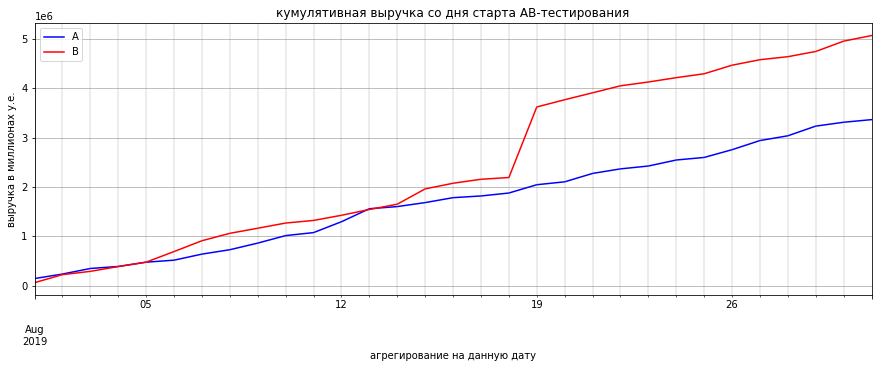

In [24]:
cax = orders_cumul_df.query('group=="A"').plot(x='date', y='cumul_revenue', color='blue', label='A', figsize=(15,5))
orders_cumul_df.query('group=="B"').plot(ax=cax, x='date', y='cumul_revenue', color='red', label='B')

for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('кумулятивная выручка со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('выручка в миллионах у.е.')
plt.grid()
plt.legend()
plt.show()


### Выводы по графику кумулятивной выручки:
1. Эффект увеличения выручки в группе В виден, однако основной гандикап группе В обеспечен огромным выбросом от покупки 19 августа 2019 на более одного миллиона у.е. 
2. Для корректного анализа эффекта от гипотезы в дальнейшем следует убрать данный выброс- на его фоне плохо различим эффект от гипотезы.

## График кумулятивного среднего чека по группам (корректность 100%)
**Определение**: *Кумулятивный средний чек на дату d_day - это отношение суммарного ревеню на d_day к количеству уникальных заказов на d_day*.

Нам подойдет уже созданный датасет orders_cumul_df - никакие изменения или дополнения на уровне датасетов не нужны:

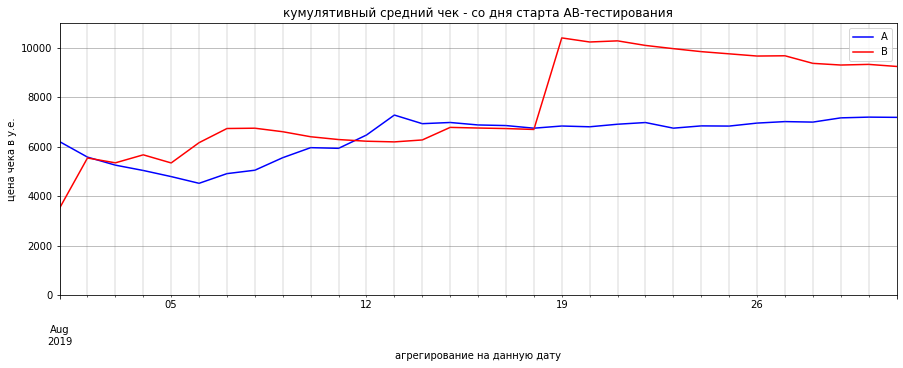

In [25]:
cax=orders_cumul_df.query('group=="A"').plot(x='date', y='avg_cheque', color='blue', label='A', figsize=(15,5), ylim=(0,11000))
orders_cumul_df.query('group=="B"').plot(ax=cax, x='date', y='avg_cheque', color='red', label='B')

for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает
    
plt.title('кумулятивный средний чек - со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('цена чека в у.е.')
plt.grid()
plt.legend()
plt.show()


### Выводы по графику кумулятивного среднего чека:
1. Колебания графиков как будто "устаканиваются" к середине срока, однако спустя 4 дня происходит огромный выброс в группе В и дальнейшее поведение в группе В не видно на его фоне.  
2. Постепенно новые заказы в знаменателе начинают уменьшать его эффект, однако основная часть гандикапа от выброса не успевает "съесться" до дня останова АВ-тестирования, поэтому у нас вообще нет возможности сделать какие-то выводы по сравнению среднего чека в группах по данному графику.
2. Для корректного анализа эффекта от гипотезы в дальнейшем анализе следует убрать данный выброс- на его фоне плохо различим эффект от гипотезы.

## График относительного изменения кумулятивного среднего чека группы B к группе A (корректность 100%)

### Построение кумулятивного датасета `B_over_A_orders_cumul_df`
Будем исходить из уже созданного датасета orders_cumul_df - теперь нам нужно одну его половину поделить на другую.  Создадим соответствующий датасет B_over_A_orders_cumul_df :

In [26]:
B_over_A_orders_cumul_df = round(
    orders_cumul_df.query('group=="B"').drop(columns='group').set_index('date') / 
    orders_cumul_df.query('group=="A"').drop(columns='group').set_index('date'), 3
)

B_over_A_orders_cumul_df.tail()

,nof_orders_unique,nof_buyers_unique,cumul_revenue,avg_cheque,ARPPU,orders_per_buyer
date,,,,,,
2019-08-27,1.129,1.140,1.557,1.380,1.366,0.990
2019-08-28,1.141,1.153,1.528,1.340,1.326,0.990
2019-08-29,1.131,1.140,1.468,1.298,1.288,0.992
2019-08-30,1.154,1.169,1.497,1.296,1.280,0.987
2019-08-31,1.171,1.187,1.507,1.287,1.270,0.987


### Визуализация относительного изменения кумулятивного среднего чека

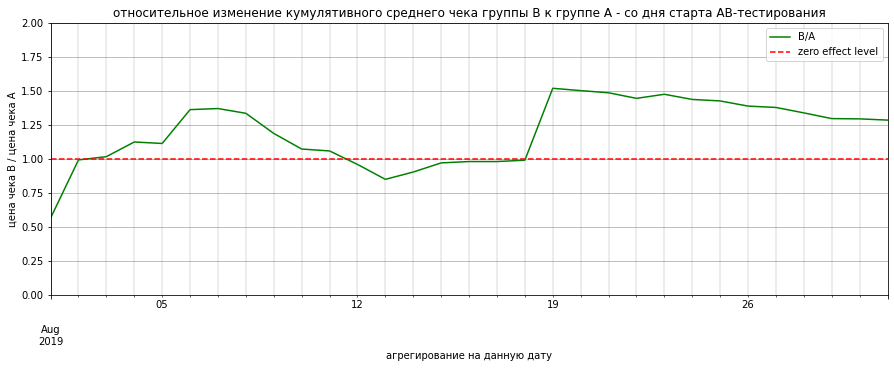

In [27]:
B_over_A_orders_cumul_df.plot( y='avg_cheque', color='green', label='B/A', figsize=(15,5), ylim=(0,2) )

plt.axhline(y=1, color='red', label='zero effect level', linestyle='--')
for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('относительное изменение кумулятивного среднего чека группы B к группе A - со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('цена чека В / цена чека А')
plt.grid()
plt.legend()
plt.show()


### Выводы по графику относительного изменения кумулятивного среднего чека:
1. Эффект целиком скрыт влиянием выброса 19 августа 2019, поэтому никаких выводов по данному графику сделать нельзя.
2. Для корректного анализа эффекта от гипотезы в дальнейшем анализе следует убрать данный выброс- на его фоне совсем неразличим эффект от гипотезы.

## График кумулятивной конверсии по группам (условно-корректно)
**Определение**: *Кумулятивная конверсия на дату d_day - это отношение кумулятивного кол-ва уникальных покупателей на дату d_day к кумулятивному кол-ву уникальных пользователей на дату d_day*.  

Кумулятивное кол-во уникальных покупателей уже посчитано в датасете orders_cumul_df.  Для дальнейшей работы удобно просто пришить к этому датасету столбец с кумулятивным количеством уникальных пользователей. Корректный рассчет данного кол-ва возможен только по датасету sessions_df, в котором есть visitor_id.  При этом кумулятивное кол-во уникальных пользователей определялось бы, например, кодом:

`sessions_df.query('group=="A/B" & date <= @d_day').groupby(['date','group'], as_index=False).agg({'visitors_id':'nunique'})`

К сожалению, в теоретической части спринта ошибочно предполагается, что кумулятивное кол-во уникальных пользователей можно определить, сложив кол-ва уникальных визитеров за каждый день до дня d_day включительно.  В связи с этим в данных проекта полностью отсутствует датасет sessions_df, и у нас нет возможности выполнить данный пункт плана проекта корректно на 100% - в связи с этим в названии пункта стоит квалификатор "условно-корректно". 

### Расширение кумулятивного датасета orders_cumul_df до `cumulative_df`  


In [28]:
# сперва строим visitors_cumul_df - ровно тем же способом, как был построен orders_cumul_df
# (поэтому нумерация индексов будет соответствовать одним и тем же date и group, кстати)

for i in range(31):
    d_day = start_date + dt.timedelta(days=i) 
    
    pair_of_lines = visitors_df.query('date <= @d_day').groupby(by=['group'], as_index=False).agg({'visitors' : 'sum'})
    pair_of_lines['date'] = pd.Series([d_day,d_day]).T
    
    if i == 0: visitors_cumul_df = pair_of_lines
    else: visitors_cumul_df = visitors_cumul_df.append(pair_of_lines)
    
visitors_cumul_df = visitors_cumul_df.rename(columns={'visitors' : 'nof_users_unique'}).reset_index(drop=True)

# и сшиваем в новый датафрейм:
cumulative_df = orders_cumul_df.join(visitors_cumul_df.drop(columns=['group','date'])) # т.к. индексы совпадают и соответствуют

# добавим сразу имеющие смысл удельные метрики
cumulative_df['CR_%'] = round( cumulative_df['nof_buyers_unique'] / cumulative_df['nof_users_unique'] *100, 3)
cumulative_df['ARPU'] = round( cumulative_df['cumul_revenue'] / cumulative_df['nof_users_unique'], 1)

cumulative_df.info() # убедимся про типы
cumulative_df # посмотрим результат как таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   group              62 non-null     object        
 1   nof_orders_unique  62 non-null     int64         
 2   nof_buyers_unique  62 non-null     int64         
 3   cumul_revenue      62 non-null     int64         
 4   date               62 non-null     datetime64[ns]
 5   avg_cheque         62 non-null     float64       
 6   ARPPU              62 non-null     float64       
 7   orders_per_buyer   62 non-null     float64       
 8   nof_users_unique   62 non-null     int64         
 9   CR_%               62 non-null     float64       
 10  ARPU               62 non-null     float64       
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 5.5+ KB


,group,nof_orders_unique,nof_buyers_unique,cumul_revenue,date,avg_cheque,ARPPU,orders_per_buyer,nof_users_unique,CR_%,ARPU
0,A,23,19,142779,2019-08-01,6207.8,7514.7,1.211,719,2.643,198.6
1,B,17,17,59758,2019-08-01,3515.2,3515.2,1.000,713,2.384,83.8
2,A,42,36,234381,2019-08-02,5580.5,6510.6,1.167,1338,2.691,175.2
3,B,40,39,221801,2019-08-02,5545.0,5687.2,1.026,1294,3.014,171.4
4,A,66,60,346854,2019-08-03,5255.4,5780.9,1.100,1845,3.252,188.0
...,...,...,...,...,...,...,...,...,...,...,...
57,B,510,490,4746610,2019-08-29,9307.1,9687.0,1.041,17708,2.767,268.0
58,A,460,437,3311413,2019-08-30,7198.7,7577.6,1.053,18037,2.423,183.6
59,B,531,511,4955833,2019-08-30,9333.0,9698.3,1.039,18198,2.808,272.3
60,A,468,445,3364656,2019-08-31,7189.4,7561.0,1.052,18736,2.375,179.6


### Визуализация кумулятивной конверсии по группам

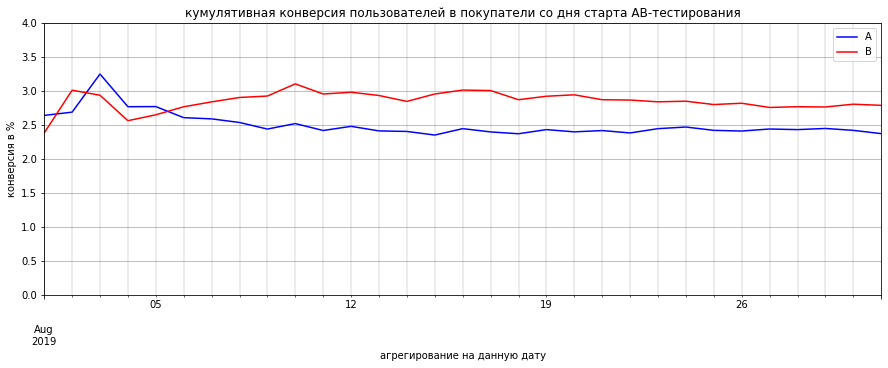

In [29]:
cax = cumulative_df.query('group=="A"').plot(x='date', y='CR_%', color='blue', label='A', figsize=(15,5), ylim=(0,4) )
cumulative_df.query('group=="B"').plot(ax=cax, x='date', y='CR_%', color='red', label='B' )

for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('кумулятивная конверсия пользователей в покупатели со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('конверсия в %')
plt.grid()
plt.legend()
plt.show()


### Выводы по графику кумулятивной конверсии по группам:
1. Выброс ревеню 19 августа 2019 ожидаемо не портит статистики по конверсии.
2. Графики "устаканиваются" за первую половину срока и далее имеют вид статистических колебаний, которые явно меньше зазора между средними уровнями в группах А и В.
3. В силу наблюдений выше можно сдалать визуальный вывод: эффект есть - в группе В конверсия порядка 2.8%, в то время как в группе A - только 2.4%
4. Для более точной визуальной оценки эффекта - см. следующую главу

## График относительного изменения кумулятивной конверсии группы B к группе A (корректность *почти* 100%)

Как это не удивительно, но данный график может быть гораздо точнее, чем прошлый - дело в том, что при равных количествах пользователей в группах А и В реальное кол-во пользователей в относительном критерии полностью сокращается, а сравнение активностей в группах дало близкий результат еще в преобработке данных: 
* группа А - 604 визитов в день;
* группа В - 610 визитов в день;
* при ожидаемом стандартном отклонении средних по обеим группам порядка ${114 \over\sqrt{62}} \approx 14.5$ !

### Проверка гипотезы о равенстве групп А и В по активности пользователей в день
Усилим наблюдение из главы по предобработке проверкой статистической значимости с которой средняя активности в группах совпадают:
* $H_0$ - нулевая гипотеза: активность пользователей в обеих группах совпадают - средние количеств дневных визитов уникальных пользователей в группах А и В за период 31 дня равны.
* $H_1$ - альтернативная гипотеза: можно быть уверенными (на приемлемом доверительном уровне), что активности различные.

Так как еще вовремя предобработки мы пришли к заключению, что распределения средних дневных активностей близки к нормальному, то в качестве критерия можно выбрать $\tau$-тест для похожих выборок с одинаковым размером и дисперсией.  Количество "измерений" в каждой выборке 31, что больше 30, так что выборки можно было бы даже анализировать и нормальной статистикой, не говоря уж о $\tau$-статистике!

In [30]:
st,pv = stats.ttest_rel( visitors_df.query('group=="B"')['visitors'] , visitors_df.query('group=="A"')['visitors'] )
print()
print('Вероятность увидеть такую разницу средних по выборкам при равенстве средних в популяциях не хуже чем в', 
      round(100 * pv,1), '% аналогичных АВ тестов')
      


Вероятность увидеть такую разницу средних по выборкам при равенстве средних в популяциях не хуже чем в 44.1 % аналогичных АВ тестов


#### Выводы по гипотезе равенства групп А и В
* Чаще чем в 2 случаях из 5 мы бы наблюдали текущий результат по визитам в группах А и В при условии, что они полностью равны.
* Таким образом, у нас нет оснований для опровержения равенства групп А и В по изначальной активности 
* К сожалению, мы не знаем как на датасет visitors_df должно повлиять выбрасывание аномального кол-ва фликеров (порядка 15% от покупателей!)

При равенстве количеств пользователей в группах отношение ${CR_B \over CR_A} = {nof\_buyers\_unique_B \over nof\_buyers\_unique_A}$, поэтому относительное изменение кумулятивной конверсии можно было бы смотреть по текущему датасету `B_over_A_orders_cumul_df['nof_buyers_unique']`, но можно и пересобрать его заново - после добавления поля CR:

### Построение кумулятивного датасета `B_over_A_cumulative_df`
Будем исходить из уже созданного датасета cumulative_df - теперь нам нужно одну его половину поделить на другую.  Создадим соответствующий датасет B_over_A_cumulative_df :

In [31]:
B_over_A_cumulative_df = round(
    cumulative_df.query('group=="B"').drop(columns='group').set_index('date') / 
    cumulative_df.query('group=="A"').drop(columns='group').set_index('date'), 3
)

B_over_A_cumulative_df.tail()

,nof_orders_unique,nof_buyers_unique,cumul_revenue,avg_cheque,ARPPU,orders_per_buyer,nof_users_unique,CR_%,ARPU
date,,,,,,,,,
2019-08-27,1.129,1.140,1.557,1.380,1.366,0.990,1.009,1.130,1.543
2019-08-28,1.141,1.153,1.528,1.340,1.326,0.990,1.012,1.138,1.509
2019-08-29,1.131,1.140,1.468,1.298,1.288,0.992,1.009,1.129,1.454
2019-08-30,1.154,1.169,1.497,1.296,1.280,0.987,1.009,1.159,1.483
2019-08-31,1.171,1.187,1.507,1.287,1.270,0.987,1.010,1.175,1.492


#### Вывод по новому датасету: 
значения в колонках CR_% и nof_buyers_unique различаются уже во второй цифре после запятой, поэтому визуализируем оба варианта для сравнения. 

### Визуализация относительного изменения кумулятивной конверсии

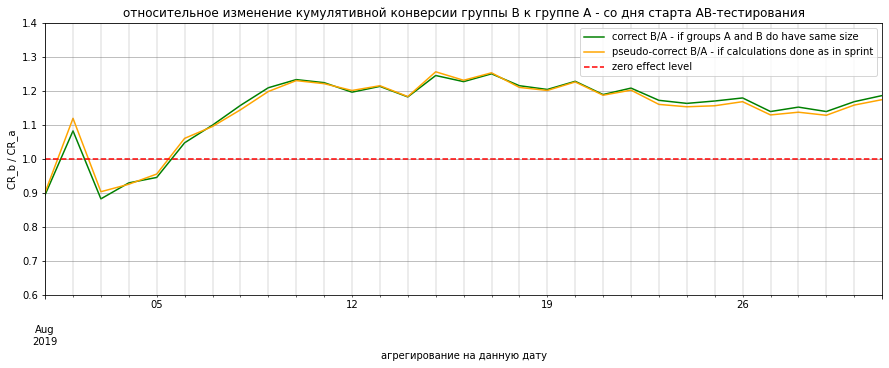

In [32]:
cax = B_over_A_cumulative_df.plot( y='nof_buyers_unique', color='green', 
                                    label='correct B/A - if groups A and B do have same size', figsize=(15,5), ylim=(0.6,1.4) )
B_over_A_cumulative_df.plot( y='CR_%', color='orange', label='pseudo-correct B/A - if calculations done as in sprint', ax=cax )

plt.axhline(y=1, color='red', label='zero effect level', linestyle='--')
for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('относительное изменение кумулятивной конверсии группы B к группе A - со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('CR_b / CR_a')
plt.grid()
plt.legend()
plt.show()


### Выводы по графику относительного изменения кумулятивной конверсии:
1. Как и ожидалось для относительного параметра кумулятивной конверсии влияние ошибки в расчете размера групп в спринте незначительно!  Поведение обеих кривых практически совпадает.
2. Кстати по их поведению можно судить о сроке "устаканивания" статистик АВ-тестирования примерно к 20-ому августу 2019 - после этого числа кривая с ошибочным вычислением размеров групп идет стабильно ниже кривой, построенной в предположении точного равенства групп.  Это стабилизировавшееся различие можно объяснить тем, что принятый в гипотезе метод для группы В повышает также пользовательскую активность - примерно на 1%, как видно и визуально и по "хвосту" датасета B_over_A_cumulative_df (мы ведь, по факту, делим покупателей на число визитов при неправильном методе из спринта). Поэтому для желтой кривой подрастает и знаменатель для группы В - и эффект в целом для В получается чуть меньше. 
3. В целом данный график подтверждает выводы прошлой главы об уверенном эффекте тестируемой гипотезы на конверсию.
4. В отличие от прошлой главы, на данном графике хорошо виден размер эффекта - на уровне 13-18% в пользу группы В.
5. Также можем уже предварительно заключить, что АВ-тест вышел на стабильный режим результатов, и что без внесения изменений продолжать АВ-тестирование нет смысла - статистически значимые результаты уже получены на 31 день тестирования.

## График поточечной развертки количества заказов по каждому покупателю (корректность 100%)
**Определение**: *график поточечной развертки - это альтернатива графикам с полупрозрачными точками для дискретных числовых значений случайной величины, предложен для понимания частоты налагающихся точек на scatter-plot - при поточечной развертке вместо наложения полупрозрачных точек имеем развертку обычных точек по инстансам вдоль оси развертки.  При этом области налагающихся точек превращаются на развертке в точки, сливающиеся в линию вдоль соответствующего дискретного значения. Там где налагающихся точек мало, линии развертки начинают прерываться все сильнее, пока не превратятся в отдельные точки на одной прямой.  Визуально это легче различать, чем густоту налагающихся точек (но добавляет единицу размерности к графику - ось развертки)*.  

При этом никакого физического смысла ось развертки не имеет и порядок отображения на ней значений параметра, по которому осуществляется развертка, также неважен.  На языке датасетов это означает, что если датасет получен группировкой по параметру развертки - то по оси развертки на графике можно брать просто индекс датасета.

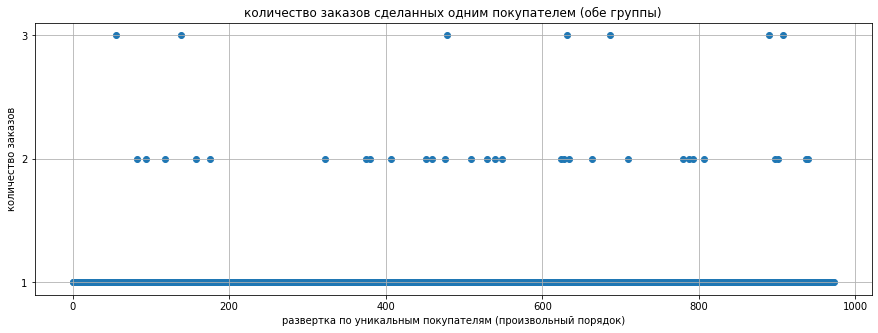

In [33]:
presentation_df = orders_df.groupby(by='visitor_id',as_index=False).agg({'transaction_id':'nunique'}).drop(columns='visitor_id')

plt.figure(figsize=(15,5))
plt.yticks([i for i in range(12)])
plt.scatter( x=presentation_df.index, y=presentation_df['transaction_id'])
plt.title('количество заказов сделанных одним покупателем (обе группы)')
plt.xlabel('развертка по уникальным покупателям (произвольный порядок)')
plt.ylabel('количество заказов')
plt.grid()
plt.show()


### Выводы по графику поточечной развертки количества заказов:
1. Распределение кол-ва завазов по покупателям сильно прижато к единице:
 * Сливающиеся во фрагменты линий только уровни 1-ого и 2-х заказов;
 * Уровень с 3-х заказов и выше представлен отдельными точками - точечное заселение;
 * После удаления фликеров из датасета orders_df другие значения заказов на одного покупателя исчезли!
2. Таким образом, те, кто делал 4 и более заказов, оказались резко-негативными по отношению к новшествам группы В, и поддержка перебросила их в группу А.  В итоге нам пришлось удалить их совсем, так как эффект на фликерах смазивается, так как они видели оба варианта А и В и эксперимент перестает быть чистым.
3. В целом график совпадает с ожиданиями от табличных выводов датасетов orders_cumul_df и/или cumulative_df - см. значения столбца orders_per_buyer (визуализация ниже): на уровне 1.05 заказа на покупателя в среднем, никаких выбросов ожидаемо не видно.

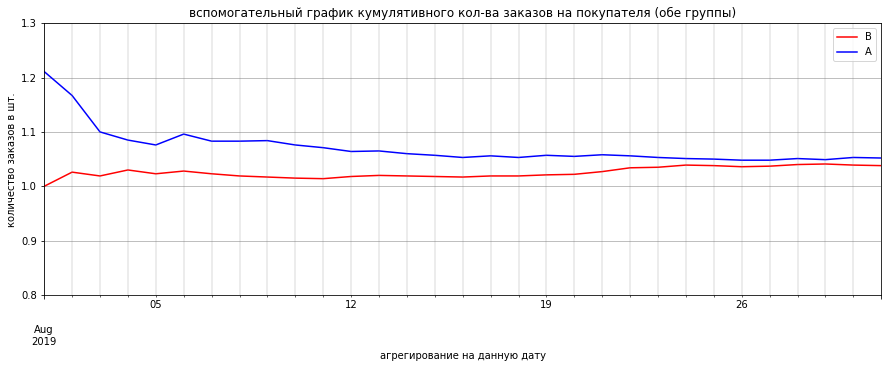

In [34]:
cax = cumulative_df.query('group=="B"').plot(
    x='date', y='orders_per_buyer', color='red', label='B', figsize=(15,5), ylim=(0.8,1.3) )
cumulative_df.query('group=="A"').plot(
    x='date', y='orders_per_buyer', color='blue', label='A', ax=cax )

for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('вспомогательный график кумулятивного кол-ва заказов на покупателя (обе группы)')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('количество заказов в шт.')
plt.grid()
plt.legend()
plt.show()


### Расчет 95 и 99 перцентиля для количества заказов по каждому покупателю

In [35]:
print('Отсечное значение для 95 перцентиля на уровне', np.percentile(presentation_df, 95))
print('Отсечное значение для 99 перцентиля на уровне', np.percentile(presentation_df, 99))

Отсечное значение для 95 перцентиля на уровне 1.0
Отсечное значение для 99 перцентиля на уровне 2.0


### Решение по границе для аномальных значений `maxlim_nof_orders_per_buyer` ( или `buyers_black_list`)
1. После удаления фликеров все аномальные значения исчезли, поэтому в реальной ситуации никакой необходимости в их удалении бы не возникло.
2. Но чтобы сохранить содержательность отдельных последующих глав проекта установим границу для удаления аномальных значений заказов на покупателя на уровне 2 включительно:

In [36]:
maxlim_nof_orders_per_buyer = 2

# однако быстро фильтровать по данному параметру не получится, так как в датасетах отсутствует данный столбец 
# поэтому составим черный список покупателей, превысивших данный лимит:
buyers_black_list = list( orders_df.groupby(by='visitor_id',as_index=False).agg({'transaction_id':'nunique'}).query(
    'transaction_id > @maxlim_nof_orders_per_buyer')['visitor_id'] )

# посмотрим как повлияло удаление аномальных выбросов на статистику распределения кол-ва заказов на одного покупателя:
before_df = orders_df.groupby(by='visitor_id',as_index=False).agg({'transaction_id':'nunique'}).rename(
    columns={'transaction_id':'before'})
after_df = before_df.query('visitor_id not in @buyers_black_list').rename(columns={'before':'after'})

statistics_df = pd.DataFrame( [before_df['before'].describe(), after_df['after'].describe()] ).T
statistics_df['change_%'] = round((statistics_df['after'] - statistics_df['before']) / statistics_df['before'] *100, 2)
statistics_df

,before,after,change_%
count,973.000000,966.000000,-0.72
mean,1.044193,1.030021,-1.36
std,0.238090,0.170733,-28.29
min,1.000000,1.000000,0.00
25%,1.000000,1.000000,0.00
50%,1.000000,1.000000,0.00
75%,1.000000,1.000000,0.00
max,3.000000,2.000000,-33.33


#### Выводы по влиянию удаления аномальных выбросов на распределение количества заказов по каждому покупателю
1. Было выброшено 0.7% значений.
2. Среднее значение уменьшилось на 1.4%.
3. Существенным образом улучшилась дисперсия - стандартное отклонение "похудело" почти на 1/3.
4. Все квартили остались на своих базовых значениях без изменений.
5. Как уже говорилось, данное удаление носит чисто-технический характер - чтобы сохранить содержательность отдельных глав проекта в дальнейшем.

## График поточечной развертки стоимости одного заказа (корректность 100%)

Все действия с данными аналогичны действиям в прошлой главе, только проще - группировка датасета не нужна, так как датафрейм orders_df уже изначально содержит уникальные заказы:

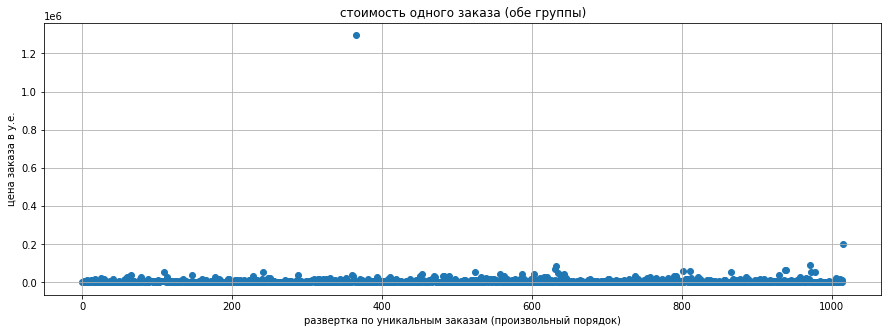

In [37]:
plt.figure(figsize=(15,5))
#plt.yticks([i*10000 for i in range(11)])
#plt.ylim(0,100000)
plt.scatter( x=orders_df.index, y=orders_df['revenue'])
plt.title('стоимость одного заказа (обе группы)')
plt.xlabel('развертка по уникальным заказам (произвольный порядок)')
plt.ylabel('цена заказа в у.е.')
plt.grid()
plt.show()


**Вот тут уже точно видны выбросы, влияющие на статистику распределения!**

Сделаем zoom на заказах в 10 раз - до 100000:

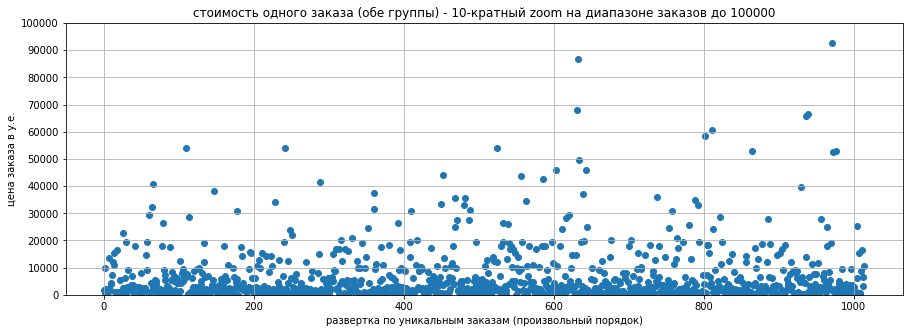

In [38]:
plt.figure(figsize=(15,5))
plt.yticks([i*10000 for i in range(11)])
plt.ylim(0,100000)
plt.scatter( x=orders_df.index, y=orders_df['revenue'])
plt.title('стоимость одного заказа (обе группы) - 10-кратный zoom на диапазоне заказов до 100000')
plt.xlabel('развертка по уникальным заказам (произвольный порядок)')
plt.ylabel('цена заказа в у.е.')
plt.grid()
plt.show()


### Выводы по графику поточечной развертки стоимости одного заказа:
1. Картина радикально отличается от аналогичной для кол-ва заказов по покупателям:
 * Значения в выбросах различаются на порядки величин;
 * Наблюдается в какой-то степени фрактальный тип поведения распределения: даже zoom в 10 раз не поменял характера распределения - все прижато к оси Х;
 * Только применение 10-кратного zoom во-второй раз (100-кратный в сумме) показывает нам что-то отличное от дельта-функции вблизи нуля!
2. Таким образом, выбросы данного распределения сильнейшим образом искажают его статистику.
3. Это совпадает с ожиданиями от предобработки данных исходных датасетов.

### Расчет 95 и 99 перцентиля для стоимости одного заказа

In [39]:
print('Отсечное значение для 95 перцентиля на уровне', round(np.percentile(orders_df['revenue'], 95)))
print('Отсечное значение для 99 перцентиля на уровне', round(np.percentile(orders_df['revenue'], 99)))

Отсечное значение для 95 перцентиля на уровне 26785
Отсечное значение для 99 перцентиля на уровне 53904


In [40]:
# вспомогательный вывод статистики стоимости одного заказа - повтор анализа из предобработки данных:
orders_df['revenue'].describe().astype('int')

count       1016
mean        8300
std        42121
min           50
25%         1190
50%         2955
75%         8134
max      1294500
Name: revenue, dtype: int32

### Решение по границе для аномальных значений `maxlim_revenue_per_order`
1. Аномальные выбросы со значениями в сотни раз превышающими медианные значения не дают нам увидеть межгрупповой эффект по основному бизнес-параметру - по ревеню.  Поэтому установление границы для отсечки аномальных значений по ревеню обязательно для успешного анализа.
2. Основываясь на графике развертки и персентилях, а также на статистике датасета выше, граница отсечки принимается на уровне примерно 15-кратного медианного значения:

In [41]:
maxlim_revenue_per_order = 45000

In [42]:
# посмотрим, как это поменяет статистику распределения
orders_df.query('revenue <= @maxlim_revenue_per_order')['revenue'].describe().astype('int')

count      998
mean      5988
std       7629
min         50
25%       1190
50%       2840
75%       7496
max      43990
Name: revenue, dtype: int32

#### Выводы по влиянию удаления аномальных выбросов на распределение цены одного заказа
1. Было выброшено 1.8% значений.
2. Медианное значение уменьшилось всего на 3.9% но при этом стандартное отклонение уменьшилось в 5.5 раза!
3. Распределение осталось перекошенным:
 * среднее вдвое больше медианы;
 * стандартное отклонение больше среднего.
4. Все это еще раз подтверждает закон Парето для распределений результатов человеческой деятельности.
5. Однако наши маркетинговые инициативы, да и сам подход АВ-тестирования как критерия их успешности, адресуют именно "серую массу", поэтому удаление "людей-Х" из анализа должно способствовать повышению точности анализа АВ-теста.

## Исследование статистической значимости различий в конверсии между группами по «сырым» данным (условно-корректно)
Для исследования статистической значимости нам нужны все пользователи групп с признаком покупатель или нет.  Как уже отмечалось ранее, для корректного определения таковых необходим исходный датасет по сессиям sessions_df, который отсутствует в исходных данных проекта из-за ошибки в теорчасти спринта.  Тут нам не поможет даже предположение о равности размеров групп.  Поэтому будем использовать ошибочный метод определения количества непокупателей в группах, принятый в спринте.

**Дисклеймер**: сразу оговоримся, что поскольку неверный метод подсчета количеств непокупателей в группах завышает данную величину, то и статистическая значимость АВ-теста будет завышена.  То есть наша неверная оценка даже не является "оценкой снизу" в отношении статистической значимости.   Поэтом в реальной ситуации мы должны были бы затребовать датасет sessions_df для выводов про статистическую значимость.

### Создание выборок для сравнения статистическим тестом

In [43]:
buyers_list_B = list(orders_df.query('group=="B"').groupby(by='visitor_id').agg({'transaction_id':'nunique'})['transaction_id'])
print('Кол-во покупателей в группе В (корректно):'.ljust(45), len(buyers_list_B))

non_buyers_list_B = [0 for i in range(visitors_df.query('group=="B"')['visitors'].sum()-len(buyers_list_B))]
print('Кол-во непокупателей в группе В (из спринта):'.ljust(45), len(non_buyers_list_B))

buyers_list_A = list(orders_df.query('group=="A"').groupby(by='visitor_id').agg({'transaction_id':'nunique'})['transaction_id'])
print('Кол-во покупателей в группе A (корректно):'.ljust(45), len(buyers_list_A))

non_buyers_list_A = [0 for i in range(visitors_df.query('group=="A"')['visitors'].sum()-len(buyers_list_A))]
print('Кол-во непокупателей в группе A (из спринта):'.ljust(45), len(non_buyers_list_A))

CR_sample_B = buyers_list_B + non_buyers_list_B
print('Размер группы В (из спринта):'.ljust(45), len(CR_sample_B))

CR_sample_A = buyers_list_A + non_buyers_list_A
print('Размер группы A (из спринта):'.ljust(45), len(CR_sample_A))

Кол-во покупателей в группе В (корректно):    528
Кол-во непокупателей в группе В (из спринта): 18388
Кол-во покупателей в группе A (корректно):    445
Кол-во непокупателей в группе A (из спринта): 18291
Размер группы В (из спринта):                 18916
Размер группы A (из спринта):                 18736


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении конверсий в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [44]:
st, pvalue = stats.mannwhitneyu(CR_sample_B, CR_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,4))

print('Конверсия в группе В превышает таковую в группе А на', 
      round( 100* (np.mean(np.sign(CR_sample_B)) / np.mean(np.sign(CR_sample_A))-1), 1), '%')

pvalue по Манну-Уитни равен 0.011
Конверсия в группе В превышает таковую в группе А на 17.5 %


### Выводы по статистической значимости различий в конверсии между группами по «сырым» данным:
1. Статистическая значимость различий позволяет принять наличие эффекта.
2. Текущая вероятность правильности заключения выше на уровне 98.9% повторяемости результата тестирования.
3. Рекомендуется при наличии ресурса принять меры по повышению мощности теста до 99% - за счет увеличения размера групп.
4. Простое продолжение тестирования не внесет существенных улучшений в статистическую значимость теста.
5. Относительный эффект по конверсии между группами 17.5% в пользу В
6. Вполне вероятно, что удаление аномальных значений улучшит статистическую значимость - проверка в следующей главе.

## Исследование статистической значимости различий в конверсии между группами по «очищенным» данным (условно-корректно)
Можно не повторять те же действия, но обрезать финальные образцы для сравнения

### Создание выборок для сравнения статистическим тестом

In [45]:
good_CR_sample_A = []
for i in range(len(CR_sample_A)): 
    if CR_sample_A[i] <= maxlim_nof_orders_per_buyer:
        good_CR_sample_A.append(CR_sample_A[i])

good_CR_sample_B = []
for i in range(len(CR_sample_B)): 
    if CR_sample_B[i] <= maxlim_nof_orders_per_buyer:
        good_CR_sample_B.append(CR_sample_B[i])

print('Размер очищенной группы В (из спринта):'.ljust(45), len(good_CR_sample_B))
print('Размер очищенной группы A (из спринта):'.ljust(45), len(good_CR_sample_A))

Размер очищенной группы В (из спринта):       18914
Размер очищенной группы A (из спринта):       18731


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении конверсий в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [46]:
st, pvalue = stats.mannwhitneyu(good_CR_sample_B, good_CR_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,4))

print('Конверсия в группе В превышает таковую в группе А на', 
      round( 100* (np.mean(np.sign(good_CR_sample_B)) / np.mean(np.sign(good_CR_sample_A)) -1), 1), '%')

pvalue по Манну-Уитни равен 0.008
Конверсия в группе В превышает таковую в группе А на 18.4 %


### Выводы по статистической значимости различий в конверсии между группами по «очищенным» данным:
1. Можно уверенно принять альтернативную гипотезу и признать наличие статистически значимого эффекта между группами по конверсии в пользу В.
2. После отбрасывания аномальных значений pvalue улучшилось с 0.011 до 0.008, пройдя критический уровень 0.010 статистической значимости.
3. Относительный эффект по конверсии между группами 18.4% в пользу В.

## Исследование статистической значимости различий в среднем чеке заказа между группами по «сырым» данным (корректность 100%)
В отличие от конверсии распределение стоимости чека по заказам - это сам датасет orders_df, и никаких заказов с нулевой суммой к нему пришивать не нужно! 

### Создание выборок для сравнения статистическим тестом

In [47]:
cheque_sample_B = list(orders_df.query('group=="B"')['revenue'])
print('Размер выборки заказов по группе В:'.ljust(30), len(cheque_sample_B))

cheque_sample_A = list(orders_df.query('group=="A"')['revenue'])
print('Размер выборки заказов по группе A:'.ljust(30), len(cheque_sample_A))

Размер выборки заказов по группе В: 548
Размер выборки заказов по группе A: 468


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении стоимости среднего чека в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [48]:
st, pvalue = stats.mannwhitneyu(cheque_sample_B, cheque_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,2))

print('Средний чек в группе В превышает таковой в группе А на', 
      round(100*(np.mean(cheque_sample_B)/np.mean(cheque_sample_A) -1), 1), '%')

pvalue по Манну-Уитни равен 0.83
Средний чек в группе В превышает таковой в группе А на 28.7 %


### Выводы по статистической значимости различий в среднем чеке заказа между группами по «сырым» данным:
1. Статистическая значимость различий не позволяет принять наличие эффекта.
2. Нет основания отвергать нулевую гипотезу.
3. Вполне вероятно, что удаление аномальных значений улучшит статистическую значимость - проверка в следующей главе.

## Исследование статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным (условно-корректно)
Поскольку тут ничего не сшивается, а парамерт обрезания аномальных значений является полем датасета, то проще всего будет повторить код сборки датасетов, внеся изменение в условия среза данных.

### Создание выборок для сравнения статистическим тестом

In [49]:
good_cheque_sample_B = list(orders_df.query('group=="B" & revenue <= @maxlim_revenue_per_order')['revenue'])
print('Размер очищенной выборки заказов по группе В:'.ljust(35), len(good_cheque_sample_B))

good_cheque_sample_A = list(orders_df.query('group=="A" & revenue <= @maxlim_revenue_per_order')['revenue'])
print('Размер очищенной выборки заказов по группе A:'.ljust(35), len(good_cheque_sample_A))

Размер очищенной выборки заказов по группе В: 541
Размер очищенной выборки заказов по группе A: 457


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении среднего чека в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [50]:
st, pvalue = stats.mannwhitneyu(good_cheque_sample_B, good_cheque_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,2))

print('Средний чек в группе В превышает таковой в группе А на', 
      round(100*(np.mean(good_cheque_sample_B)/np.mean(good_cheque_sample_A)-1), 1), '%')

pvalue по Манну-Уитни равен 0.94
Средний чек в группе В превышает таковой в группе А на 2.3 %


### Выводы по статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным:
1. Статистическая значимость различий не позволяет принять наличие эффекта.
2. Нет основания отвергать нулевую гипотезу.
3. Удаление аномальных значений лишь добавило уверенности в оставлении нулевой гипотезы:
 * pvalue еще сильнее приблизилось к 1 - до 0.94;
 * радикальным образом сократилось различие в среднем чеке - всего 2%.

## Дополнительное исследование статистической значимости различий в ARPPU между группами по «сырым» данным (корректность 100%)
Поскольку эффект по увеличению среднего чека не получил подтверждение, анализ влияния различия между А и В на доходы подвис в воздухе.  Поэтому проведем еще одно исследование - LTV для платящего пользователя - или ARPPU.  Если эффект различия по ARPPU подтвердится, то в совокупности с уже подтвержденным эффектом для конверсии CR, из этого будет следовать и наличие подтвержденного эффекта для дохода, так как ДОХОД = ПОЛЬЗОВАТЕЛЬСКАЯ БАЗА * CR * ARPPU, и при росте двух последних множителей доход с одного и того же массового рынка тоже вырастет. 

### Создание выборок для сравнения статистическим тестом

In [51]:
ARPPU_sample_B = list(orders_df.query('group=="B"').groupby('visitor_id').agg({'revenue':'sum'})['revenue'] )
print('Размер выборки ARPPU по группе В:'.ljust(30), len(ARPPU_sample_B))

ARPPU_sample_A = list(orders_df.query('group=="A"').groupby('visitor_id').agg({'revenue':'sum'})['revenue'] )
print('Размер выборки ARPPU по группе A:'.ljust(30), len(ARPPU_sample_A))

Размер выборки ARPPU по группе В: 528
Размер выборки ARPPU по группе A: 445


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении ARPPU в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [52]:
st, pvalue = stats.mannwhitneyu(ARPPU_sample_B, ARPPU_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,2))

print('ARPPU в группе В превышает таковой в группе А на', 
      round(100*(np.mean(ARPPU_sample_B)/np.mean(ARPPU_sample_A) -1), 1), '%')

pvalue по Манну-Уитни равен 0.79
ARPPU в группе В превышает таковой в группе А на 27.0 %


### Выводы по статистической значимости различий в среднем чеке заказа между группами по «сырым» данным:
1. Статистическая значимость различий не позволяет принять наличие эффекта.
2. Нет основания отвергать нулевую гипотезу.
3. Вполне вероятно, что удаление аномальных значений улучшит статистическую значимость - проверка в следующей главе.

## Дополнительное исследование статистической значимости различий в ARPPU между группами по «очищенным» данным (корректность 100%)
Поскольку тут ничего не сшивается, а парамерт обрезания аномальных значений является полем датасета, то проще всего будет повторить код сборки датасетов, внеся изменение в условия среза данных.

### Создание выборок для сравнения статистическим тестом

In [53]:
good_ARPPU_sample_B = list(orders_df.query('group=="B" & revenue <= @maxlim_revenue_per_order').groupby(
    'visitor_id').agg({'revenue':'sum'})['revenue'] )
print('Размер очищенной выборки ARPPU по группе В:'.ljust(35), len(ARPPU_sample_B))

good_ARPPU_sample_A = list(orders_df.query('group=="A" & revenue <= @maxlim_revenue_per_order').groupby(
    'visitor_id').agg({'revenue':'sum'})['revenue'] )
print('Размер очищенной выборки ARPPU по группе A:'.ljust(35), len(ARPPU_sample_A))

Размер очищенной выборки ARPPU по группе В: 528
Размер очищенной выборки ARPPU по группе A: 445


### Проверка нулевой гипотезы критерием Манна-Уитни
Выбираем стандартным образом нулевую и альтернативную гипотезы:
* $H_0$ - нулевая гипотеза о совпадении ARPPU в группах А и В;
* $H_1$ - альтернативная гипотеза о наличии статистически-значимого эффекта различия между группами А и В

Выбираем уровни статистической значимости:
* `pvalue <= 0.01        -` принимаем альтернативную гипотезу без продолжения тестирования;
* `0.01 < pvalue <= 0.05 -` принимаем альтернативную гипотезу, но рекомендуем увеличить кол-во участников в группах и повторить тестирование 31 день;
* `pvalue > 0.05         -` остаемся при нулевой гипотезе

Проводим сравнение:

In [54]:
st, pvalue = stats.mannwhitneyu(good_ARPPU_sample_B, good_ARPPU_sample_A)
print('pvalue по Манну-Уитни равен', round(pvalue,2))

print('ARPPU в группе В превышает таковой в группе А на', 
      round(100*(np.mean(good_ARPPU_sample_B)/np.mean(good_ARPPU_sample_A)-1), 1), '%')

pvalue по Манну-Уитни равен 0.99
ARPPU в группе В превышает таковой в группе А на 1.1 %


### Выводы по статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным:
1. Статистическая значимость различий не позволяет принять наличие эффекта.
2. Нет основания отвергать нулевую гипотезу.
3. Удаление аномальных значений лишь добавило уверенности в оставлении нулевой гипотезы:
 * pvalue еще сильнее приблизилось к 1 - до 0.99;
 * радикальным образом сократилось различие в среднем чеке - до 1%.

## Дополнительный график кумулятивной выручки по группам - теперь по «очищенным» данным (корректность 100%)
Итак ни ARPPU, ни средний чек не показали эффекта, эффект был статистически достоверным только для конверсии, но исходная бизнес-цель - найим способы увеличения доходов, поэтому опять сравним выручку.  Теперь без влияния аномальных выбросов.

### Пересборка датасета без аномалий `good_orders_cumul_df`

In [55]:
for i in range(31):
    d_day = start_date + dt.timedelta(days=i) 
    
    pair_of_lines = orders_df.query( # здесь ограничим аномалии
        'date <= @d_day & revenue <= @maxlim_revenue_per_order & visitor_id not in @buyers_black_list').groupby( 
        by=['group'], as_index=False).agg({
        'transaction_id' : 'nunique', # получим сразу не только стоимость заказа, но и веса для удельных метрик
        'visitor_id' : 'nunique',     # получим сразу не только стоимость заказа, но и веса для удельных метрик
        'revenue' : 'sum'
    })
    pair_of_lines['date'] = pd.Series([d_day,d_day]).T
    
    if i == 0: good_orders_cumul_df = pair_of_lines
    else: good_orders_cumul_df = good_orders_cumul_df.append(pair_of_lines)
    
good_orders_cumul_df = good_orders_cumul_df.rename(columns={
    'transaction_id' : 'nof_orders_unique',
    'visitor_id' : 'nof_buyers_unique',
    'revenue' : 'cumul_revenue'
}).reset_index(drop=True)

# добавим сразу имеющие смысл удельные метрики
good_orders_cumul_df['avg_cheque'] = round( 
    good_orders_cumul_df['cumul_revenue'] / good_orders_cumul_df['nof_orders_unique'], 1)
good_orders_cumul_df['ARPPU'] = round( 
    good_orders_cumul_df['cumul_revenue'] / good_orders_cumul_df['nof_buyers_unique'], 1)
good_orders_cumul_df['orders_per_buyer'] = round( 
    good_orders_cumul_df['nof_orders_unique'] / good_orders_cumul_df['nof_buyers_unique'], 3)

good_orders_cumul_df.info() # убедимся про типы
good_orders_cumul_df # посмотрим результат как таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   group              62 non-null     object        
 1   nof_orders_unique  62 non-null     int64         
 2   nof_buyers_unique  62 non-null     int64         
 3   cumul_revenue      62 non-null     int64         
 4   date               62 non-null     datetime64[ns]
 5   avg_cheque         62 non-null     float64       
 6   ARPPU              62 non-null     float64       
 7   orders_per_buyer   62 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 4.0+ KB


,group,nof_orders_unique,nof_buyers_unique,cumul_revenue,date,avg_cheque,ARPPU,orders_per_buyer
0,A,18,17,112340,2019-08-01,6241.1,6608.2,1.059
1,B,17,17,59758,2019-08-01,3515.2,3515.2,1.000
2,A,36,34,202252,2019-08-02,5618.1,5948.6,1.059
3,B,40,39,221801,2019-08-02,5545.0,5687.2,1.026
4,A,60,58,314725,2019-08-03,5245.4,5426.3,1.034
...,...,...,...,...,...,...,...,...
57,B,498,482,2948003,2019-08-29,5919.7,6116.2,1.033
58,A,434,422,2544381,2019-08-30,5862.6,6029.3,1.028
59,B,518,502,3111446,2019-08-30,6006.7,6198.1,1.032
60,A,442,430,2597624,2019-08-31,5877.0,6041.0,1.028


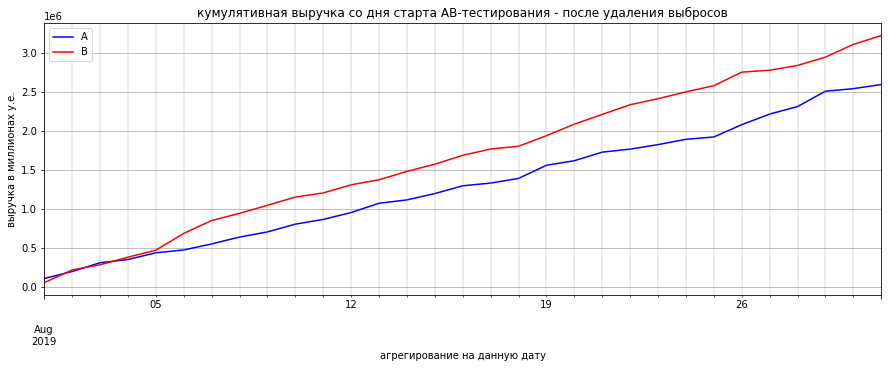

In [56]:
cax = good_orders_cumul_df.query('group=="A"').plot(x='date', y='cumul_revenue', color='blue', label='A', figsize=(15,5))
good_orders_cumul_df.query('group=="B"').plot(ax=cax, x='date', y='cumul_revenue', color='red', label='B')

for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('кумулятивная выручка со дня старта АВ-тестирования - после удаления выбросов')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('выручка в миллионах у.е.')
plt.grid()
plt.legend()
plt.show()


In [57]:
B_over_A_good_orders_cumul_df = round(
    good_orders_cumul_df.query('group=="B"').drop(columns='group').set_index('date') / 
    good_orders_cumul_df.query('group=="A"').drop(columns='group').set_index('date'), 3
)

B_over_A_good_orders_cumul_df.tail()

,nof_orders_unique,nof_buyers_unique,cumul_revenue,avg_cheque,ARPPU,orders_per_buyer
date,,,,,,
2019-08-27,1.167,1.164,1.253,1.074,1.077,1.003
2019-08-28,1.178,1.176,1.228,1.042,1.044,1.002
2019-08-29,1.166,1.161,1.174,1.007,1.011,1.004
2019-08-30,1.194,1.190,1.223,1.025,1.028,1.004
2019-08-31,1.210,1.207,1.241,1.026,1.028,1.003


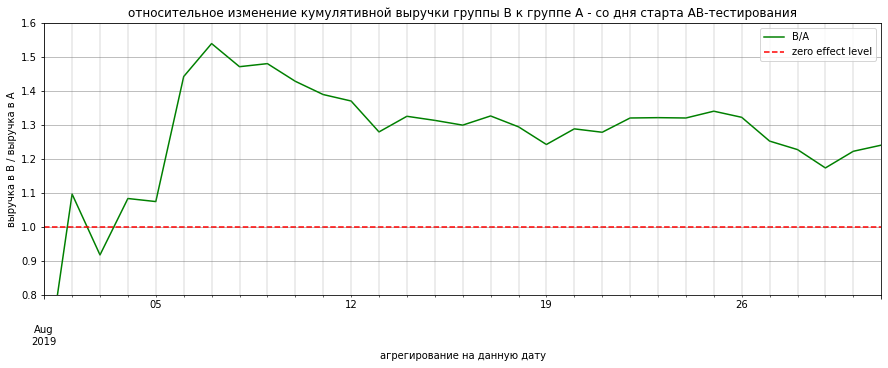

In [58]:
B_over_A_good_orders_cumul_df.plot( y='cumul_revenue', color='green', label='B/A', figsize=(15,5), ylim=(0.8,1.6) )

plt.axhline(y=1, color='red', label='zero effect level', linestyle='--')
for i in range(1,30): plt.axvline(x=start_date+dt.timedelta(days=i), color='gray', linewidth=0.3) # а то grid не прорисовывает

plt.title('относительное изменение кумулятивной выручки группы B к группе A - со дня старта АВ-тестирования')
plt.xlabel('агрегирование на данную дату')
plt.ylabel('выручка в В / выручка в А')
plt.grid()
plt.legend()
plt.show()

### Выводы по графику кумулятивной выручки по группам по «очищенным» данным:
1. Выручка в группе В на 25% +/- 8% стабильно выше выручки в группе А.  Диапазон включает найденную ранее статистически значимую разницу в конверсии CR между группами на уровне 18%. 
2. К 20 августа результаты можно считать устоявшимися - далее относительное значение флюктуирует из-за крупного масштаба графика.
3.  Если размеры групп были одинаковыми - нам это неизвестно в силу неполноты исходных данных проекта - то эффект можно считать подтвержденным.

## Результаты АВ-тестирования
**Тест следует остановить на 31-й день со следующими результатами**:
1. АВ-тестирование показало статистически значимый эффект в конверсии пользователей в покупатели на уровне 18% в пользу группы В.
2. АВ-тестирование не выявило статистически значимых различий в размере среднего чека и в ARPPU между группами.
2. Кумулятивные метрики подтвердили, что переходные процессы в тесте завершились примерно на 2/3 срока тестирования - простое продолжение тестирования как есть не улучшит статистической значимости результатов.
3. Анализ теста столкнулся с объективными недостатками, которые сильно препятствовали количественному анализу результатов:
 * процент фликеров сменивших группу в ходе проведения теста аномально высок - порядка 15%;
 * в исходных данных для анализа не представлен лог сессий пользователей, но только аггрегированные данные визитов по дням, что искажает метрики при выбрасывании пользователей и аномалий;
 * отсутствуют списки групп и даже информация об их реальных размерах.
4. Возможно, повтор тестирования после исправления перечисленных недостатков позволит сделать статистически достоверные заключения о среднем чеке и ARPPU, но в текущем виде продолжать тест нет причин.
5. Графики кумулятивной выручки показывают уверенное отличие доходов в группе В - на 25% +/- 8% по сравнению с группой А, что при условии равности групп также подтверждает наличие эффекта по результатам АВ-тестирования

**В целом тест следует признать успешным, а маркетинговую инициативу следует запускать весь на рынок, при условии, что ее ROI также уверенно больше 1 - прогноз повышения дохода в сегменте репрезентованном выборками групп на 25% от текущего, маркетинговые затраты нам не известны, чтобы проанализировать ROI здесь**

# <КОНЕЦ ДОКУМЕНТА>

In [59]:
print('If you see this, then you know that the run-all-cells command has been executed successfully!')

If you see this, then you know that the run-all-cells command has been executed successfully!
